# Summary of output from model of COVID-19 <a class="anchor" id="home"></a>

This Jupyter notebook summarises output from the [OpenABM-Covid19](https://github.com/BDI-pathogens/OpenABM-Covid19) model.  This notebook provides basic plotting functions for a single simulation of the model using a single set of parameters.  The notebook is intended as a guide for how model output may be explored.  The figures in this notebook demonstrate some of the more detailed outputs from the model including 1) the time series output, 2) summary of all simulated SARS-CoV2 transmission events in a simulated epidemic, and 3) and all interaction events between individuals on the last day of the simulated outbreak.  Model output can be generated using this notebook by evaluating the cells below.  Four larger files generated by the model will be written to file in the location specified in the variable `output_dir` below.  These files are: 

1. `individual_file_Run1.csv`: a file of all individuals in the simulated epidemic.  
2. `transmission_Run1.csv`: a file of all transmission events in the simulated epidemic.  
3. `interactions_Run1.csv`: a file of all interaction events on the final day of the simulation.  
4. `trace_tokens_Run1.csv`: a file of all contact tracing events (up to the last 14 days) that have not been released.


The figures in this notebook are not intended to be used as projections of the current COVID19 outbreak.


### Table of contents

*Output from a single simulation*
* [Parameter values and assumptions](#parameter-values-assumptions)
* [Time series](#time-series)
* [Interactions between individuals](#interactions)
* [Transmission network](#transmission-network)
* [Age-stratified outputs](#age-stratified-outputs)


*Notes*

This notebook was generated using commit number `xxxx` on Friday 17-Apr-20.

In [53]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import os, re, importlib
from os.path import join
from IPython.display import display
import plotting
plt.rcParams['figure.figsize'] = [14, 8]

### Model parameters

In [54]:
from COVID19.model import Model, Parameters, ModelParameterException
import COVID19.simulation as simulation

input_parameter_file = "../tests/data/baseline_parameters.csv"
parameter_line_number = 1
output_dir = "."
household_demographics_file = "../tests/data/baseline_household_demographics.csv"

### Run model

Simulate an epidemic with no interventions for 150 days using a population of 1 million.  

In [55]:
params = Parameters(input_parameter_file, parameter_line_number, output_dir, household_demographics_file)

T = 150
N = 100000
params.set_param("end_time", T)
params.set_param("n_total", N)

model = simulation.COVID19IBM(model = Model(params))
sim = simulation.Simulation(env = model, end_time = T)
sim.steps(150)

In [56]:
df_timeseries = pd.DataFrame(sim.results)

### Read input parameter file

In [57]:
df_parameters = pd.read_csv(input_parameter_file)

### Write/import output data

In [58]:
# Write output to file
sim.env.model.write_output_files()

# Import file with information on all individuals
df_indiv = pd.read_csv(join(output_dir, "individual_file_Run1.csv"), skipinitialspace = True)

# Import transmission file
df_trans = pd.read_csv(join(output_dir, "transmission_Run1.csv"))

# Import data on interactions in the last day of the simulation
df_interact = pd.read_csv(join(output_dir, "interactions_Run1.csv"))

### Define plotting constants

In [78]:
from COVID19.model import AgeGroupEnum, EVENT_TYPES, TransmissionTypeEnum
infector_types = [e.value for e in EVENT_TYPES]
infector_labels = [e.name for e in EVENT_TYPES]

interaction_types = [c.value for c in TransmissionTypeEnum ]
interaction_labels = [c.name[1:].title() for c in TransmissionTypeEnum]

infectious_compartments = ["PRESYMPTOMATIC", "PRESYMPTOMATIC_MILD", "ASYMPTOMATIC", "SYMPTOMATIC", "SYMPTOMATIC_MILD"]
infectious_types = [e.name for e in EVENT_TYPES if e.name in infectious_compartments]
infectious_labels = [plotting.EVENT_TYPE_STRING[e.value] for e in EVENT_TYPES if e.name in infectious_compartments]

# Define age groups and labels <- FIXME: change to Enum in constant.py
n_age = len(AgeGroupEnum) + 1
age_group_labels = [enum.name[1:].replace("_","-") for enum in AgeGroupEnum]
age_group_labels[-1] = "80+"

# Parameter values and assumptions <a class="anchor" id="parameter-values-assumptions"></a>
[[Home](#home)]

Key parameter values for the simulations below.  

In [60]:
df_parameters[plotting.key_params].T.set_axis(["Parameter value"], axis = 1, inplace = False).rename_axis("Parameter name", axis = 0).reset_index().style.hide_index().set_precision(4)

Parameter name,Parameter value
n_seed_infection,5.0000
infectious_rate,5.7500
asymptomatic_infectious_factor,0.2900
mild_infectious_factor,0.4800
daily_non_cov_symptoms_rate,0.0020


## Waiting time distributions

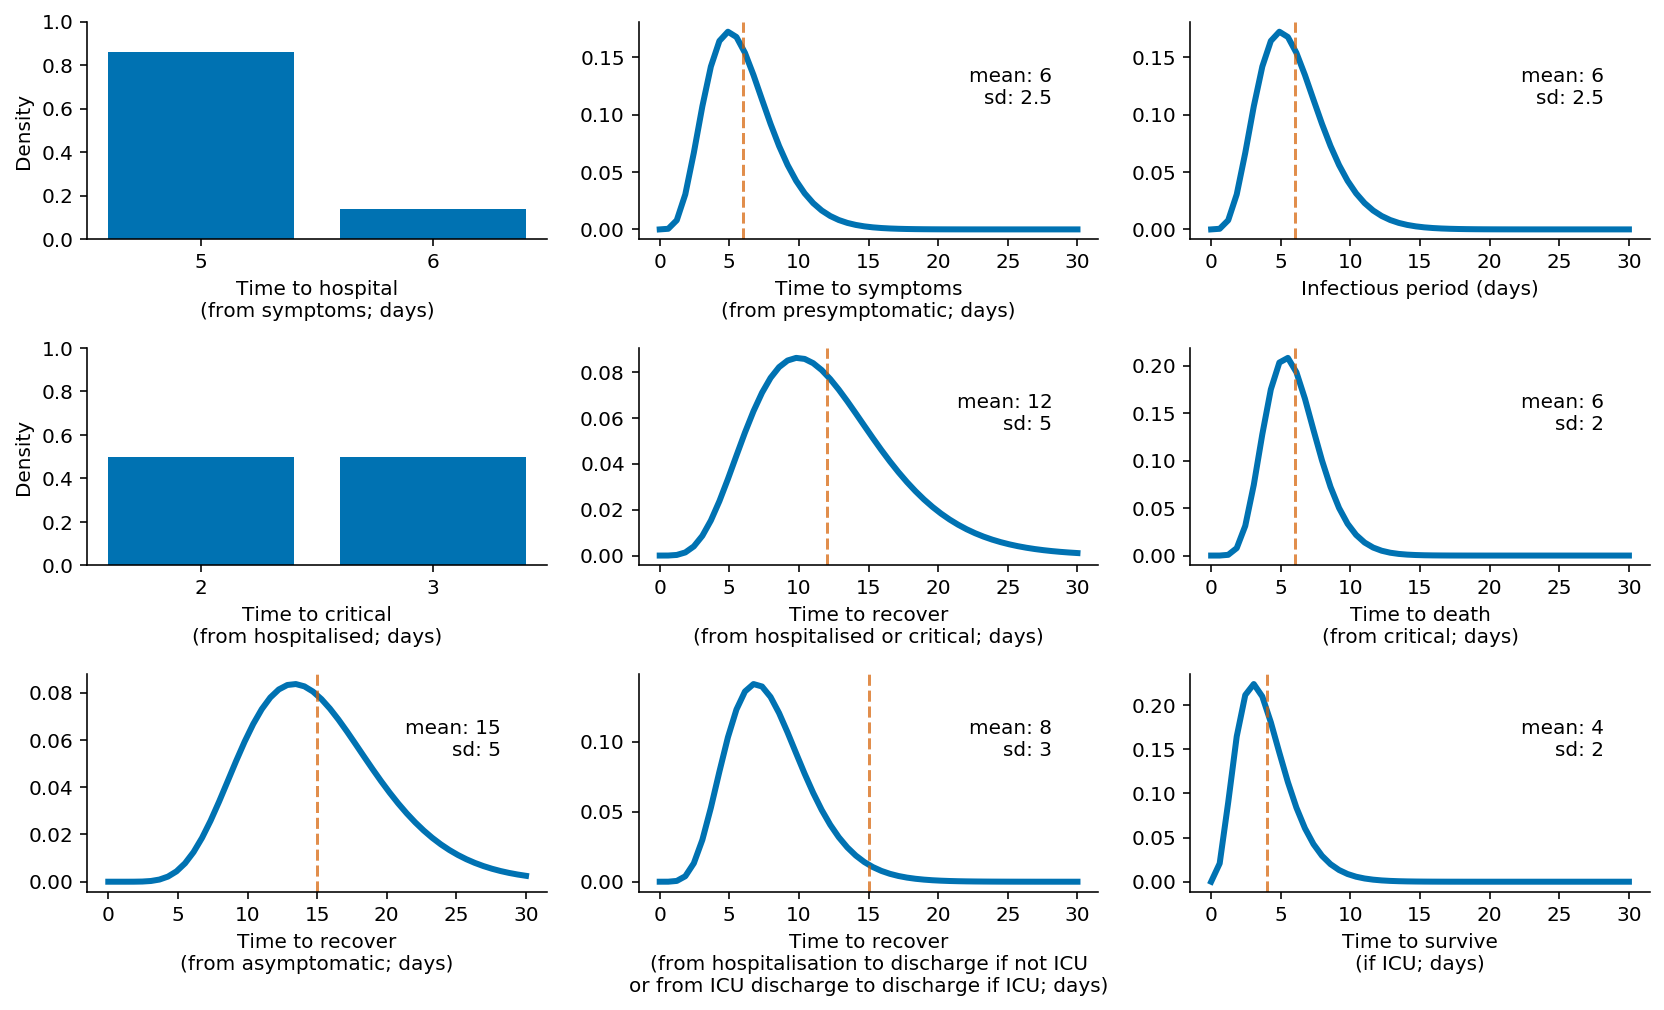

In [61]:
fig, ax = plotting.ParameterAssumptions(df_parameters)

## Age-specific parameters

In [62]:
age_params = [
    df_parameters[plotting.susceptibility_cols].values[0],
    df_parameters[plotting.asymptomatic_cols].values[0],
    df_parameters[plotting.hospitalised_cols].values[0],
    df_parameters[plotting.critical_cols].values[0],
    df_parameters[plotting.fatality_cols].values[0],
    df_parameters[plotting.mild_cols].values[0],
    df_parameters[plotting.app_users_cols].values[0],
    df_parameters[plotting.population_cols].values[0]]

df = pd.DataFrame(age_params); df.columns = age_group_labels
df.rename(index = {0:'Relative susceptibility', 
                   1:'Pr( asymptomatic | infected )',
                   2:'Pr( hospitalisation | symptomatic )',
                   3:'Pr( ICU | hospitalised )',
                   4:'Pr( death | ICU )',
                   5:'Pr( mild | infected )',
                   6:'Pr( app users )',
                   7: 'Relative pop size'
                  }, inplace = True)
display(df.style.set_precision(4))

,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
Relative susceptibility,0.7100,0.7400,0.7900,0.8700,0.9800,1.1100,1.2600,1.4500,1.6600
Pr( asymptomatic | infected ),0.1800,0.1800,0.1800,0.1800,0.1800,0.1800,0.1800,0.1800,0.1800
Pr( hospitalisation | symptomatic ),0.0100,0.0267,0.0367,0.0633,0.8000,0.1200,0.1533,0.1600,0.1367
Pr( ICU | hospitalised ),0.0500,0.0500,0.0500,0.0500,0.0630,0.1220,0.2740,0.4320,0.7090
Pr( death | ICU ),0.3300,0.2500,0.5000,0.5000,0.5000,0.6900,0.6500,0.8800,1.0000
Pr( mild | infected ),0.7900,0.7900,0.7300,0.6800,0.6500,0.5900,0.5300,0.4100,0.2700
Pr( app users ),0.0000,0.9000,0.9600,0.9500,0.9100,0.8100,0.6400,0.4100,0.2700
Relative pop size,8054000.0000,7528000.0000,8712000.0000,8835000.0000,8500000.0000,8968000.0000,7069000.0000,5488000.0000,3281000.0000


# Time series <a class="anchor" id="time-series"></a>
[[Home](#home)]

Plot the epidemic trajectory for a single parameter set.  

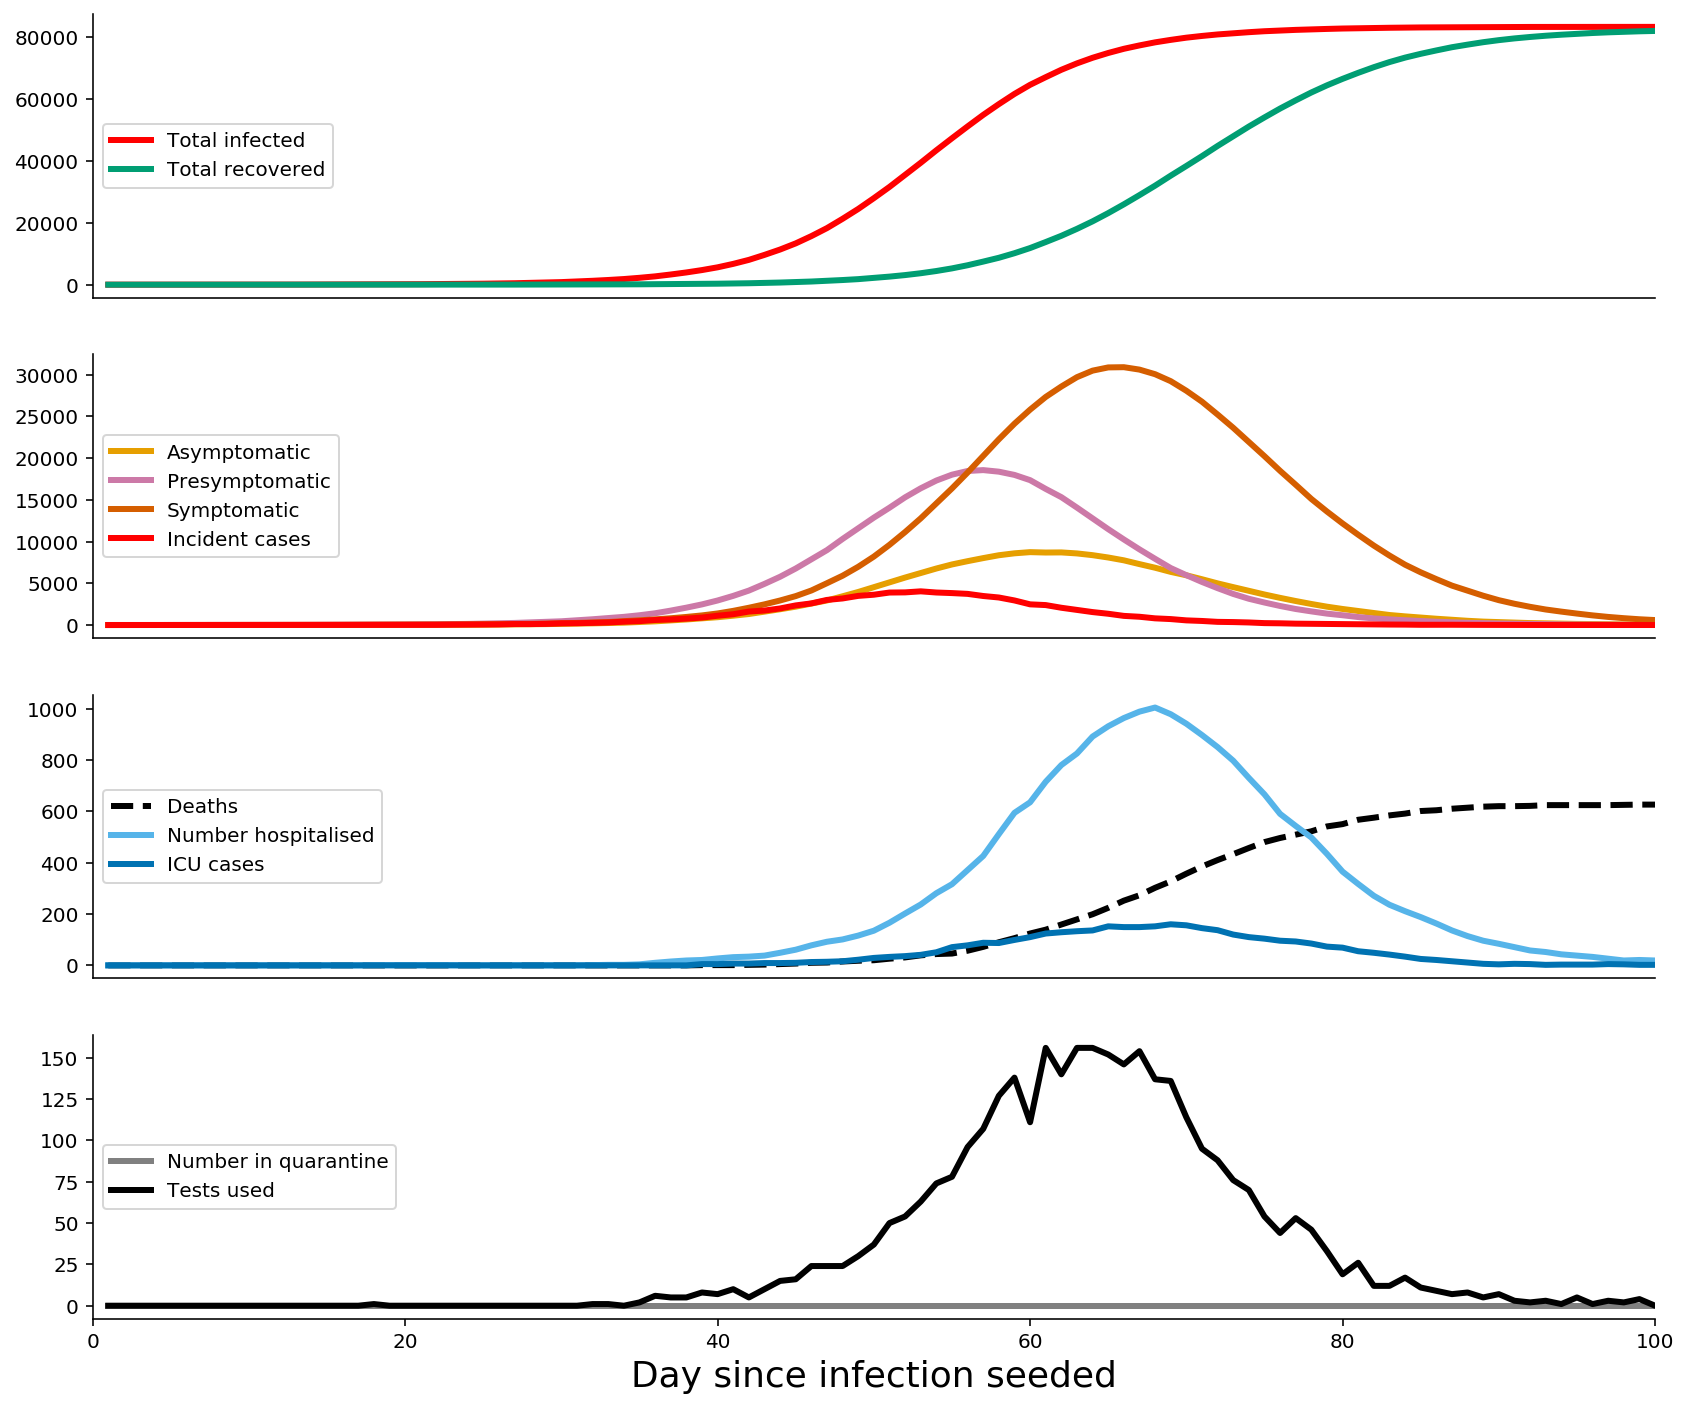

In [63]:
importlib.reload(plotting)
plt.rcParams['figure.figsize'] = [14, 12]
fig, ax = plotting.EpidemicCurves(df_timeseries, xlimits = [0, 100])

# Interactions <a class="anchor" id="interactions"></a>
[[Home](#home)]

Summaries of interactions in the final day of the simulation.  


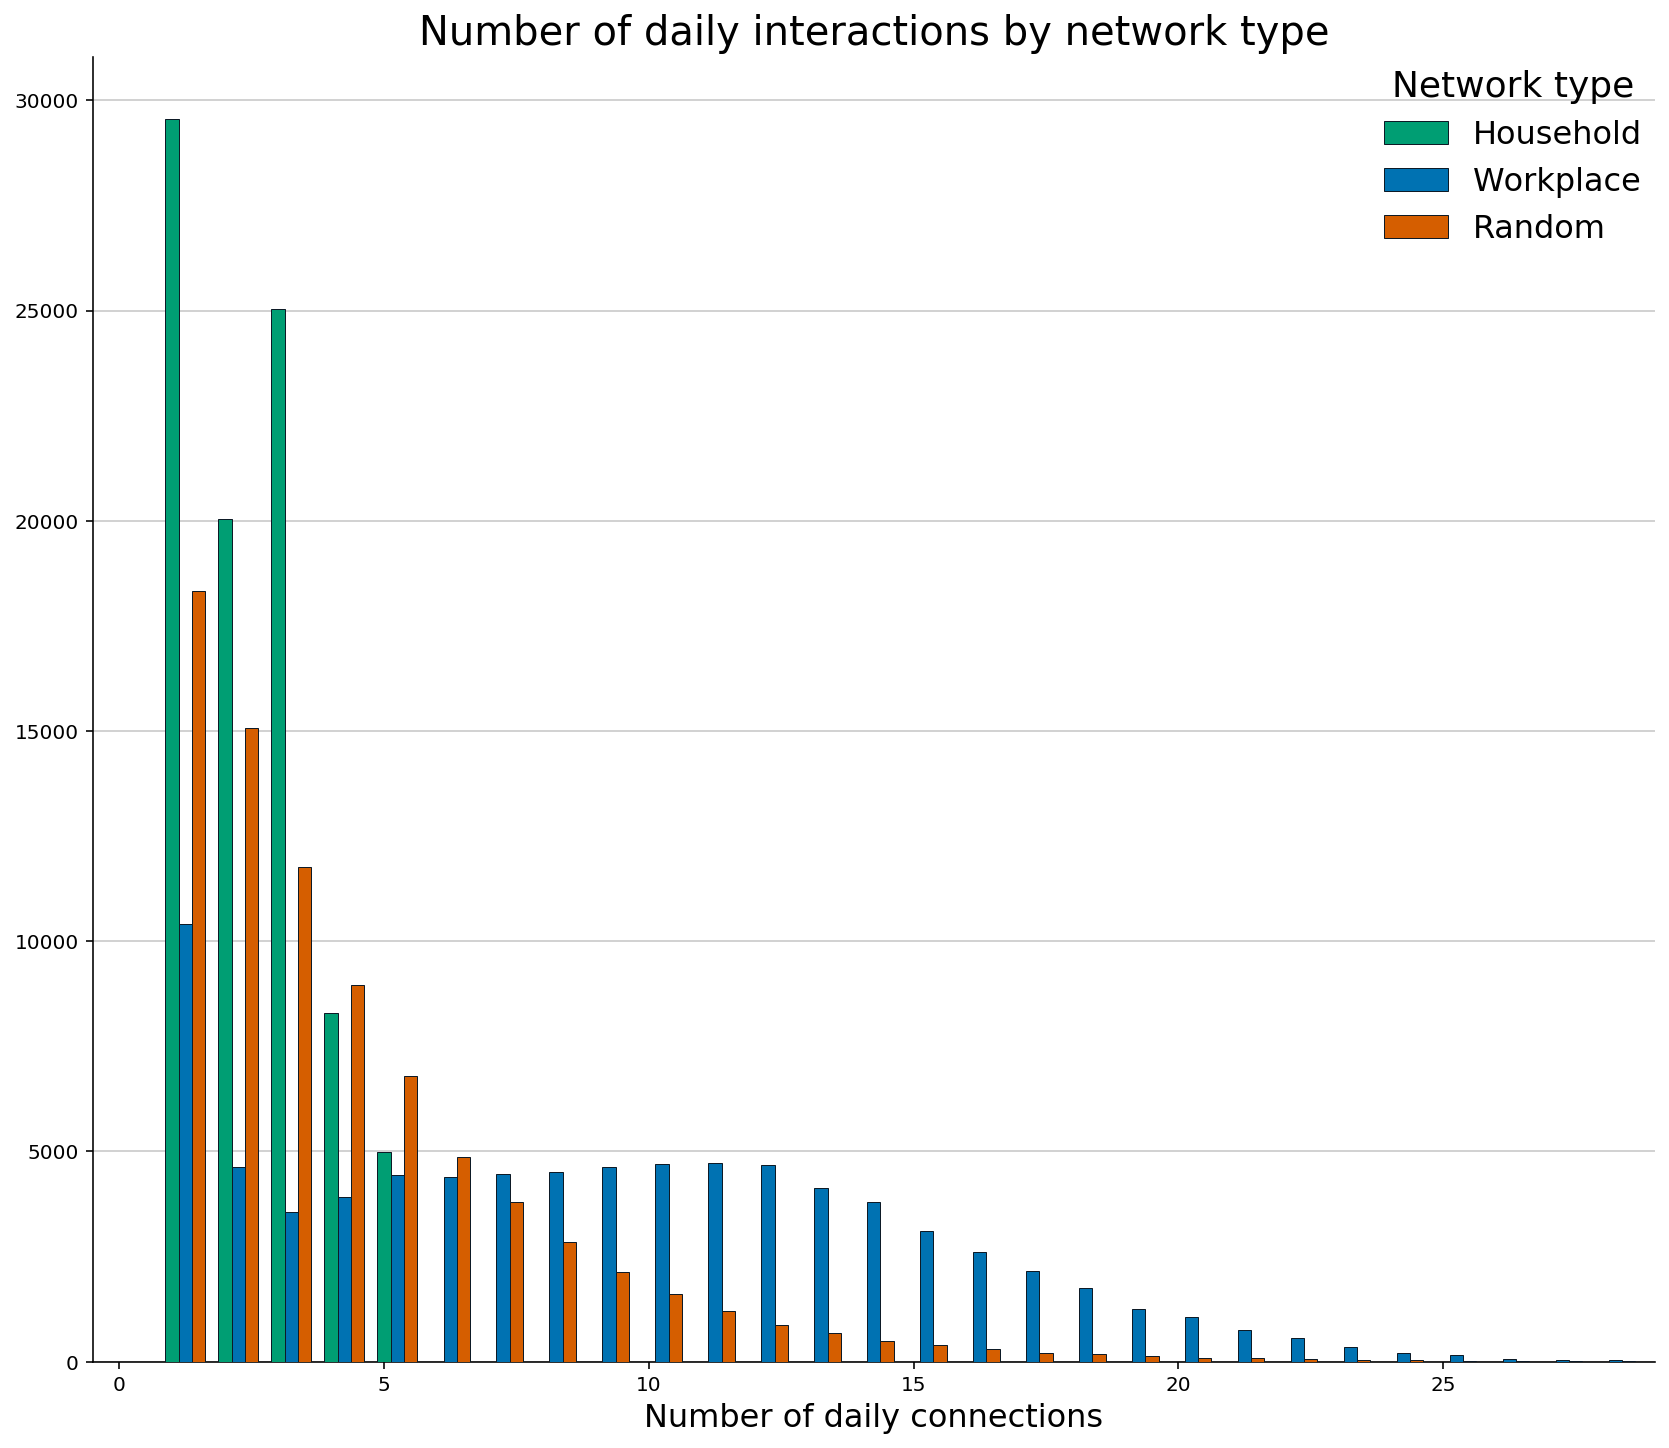

In [64]:
# Count interactions for each individual by "type" of interaction
df_agg = df_interact.groupby(["ID", "type"])["ID"].count().reset_index(name = "count")

# Plot histogram of interaction by network type
fig, ax = plotting.BarByGroup(df_agg, groupvar = "type", binvar = "count", 
    groups = interaction_types, bins = 30, group_colours = plotting.network_colours, 
    group_labels = interaction_labels, 
    xlabel = "Number of daily connections", 
    title = "Number of daily interactions by network type", 
    legend_title = "Network type")

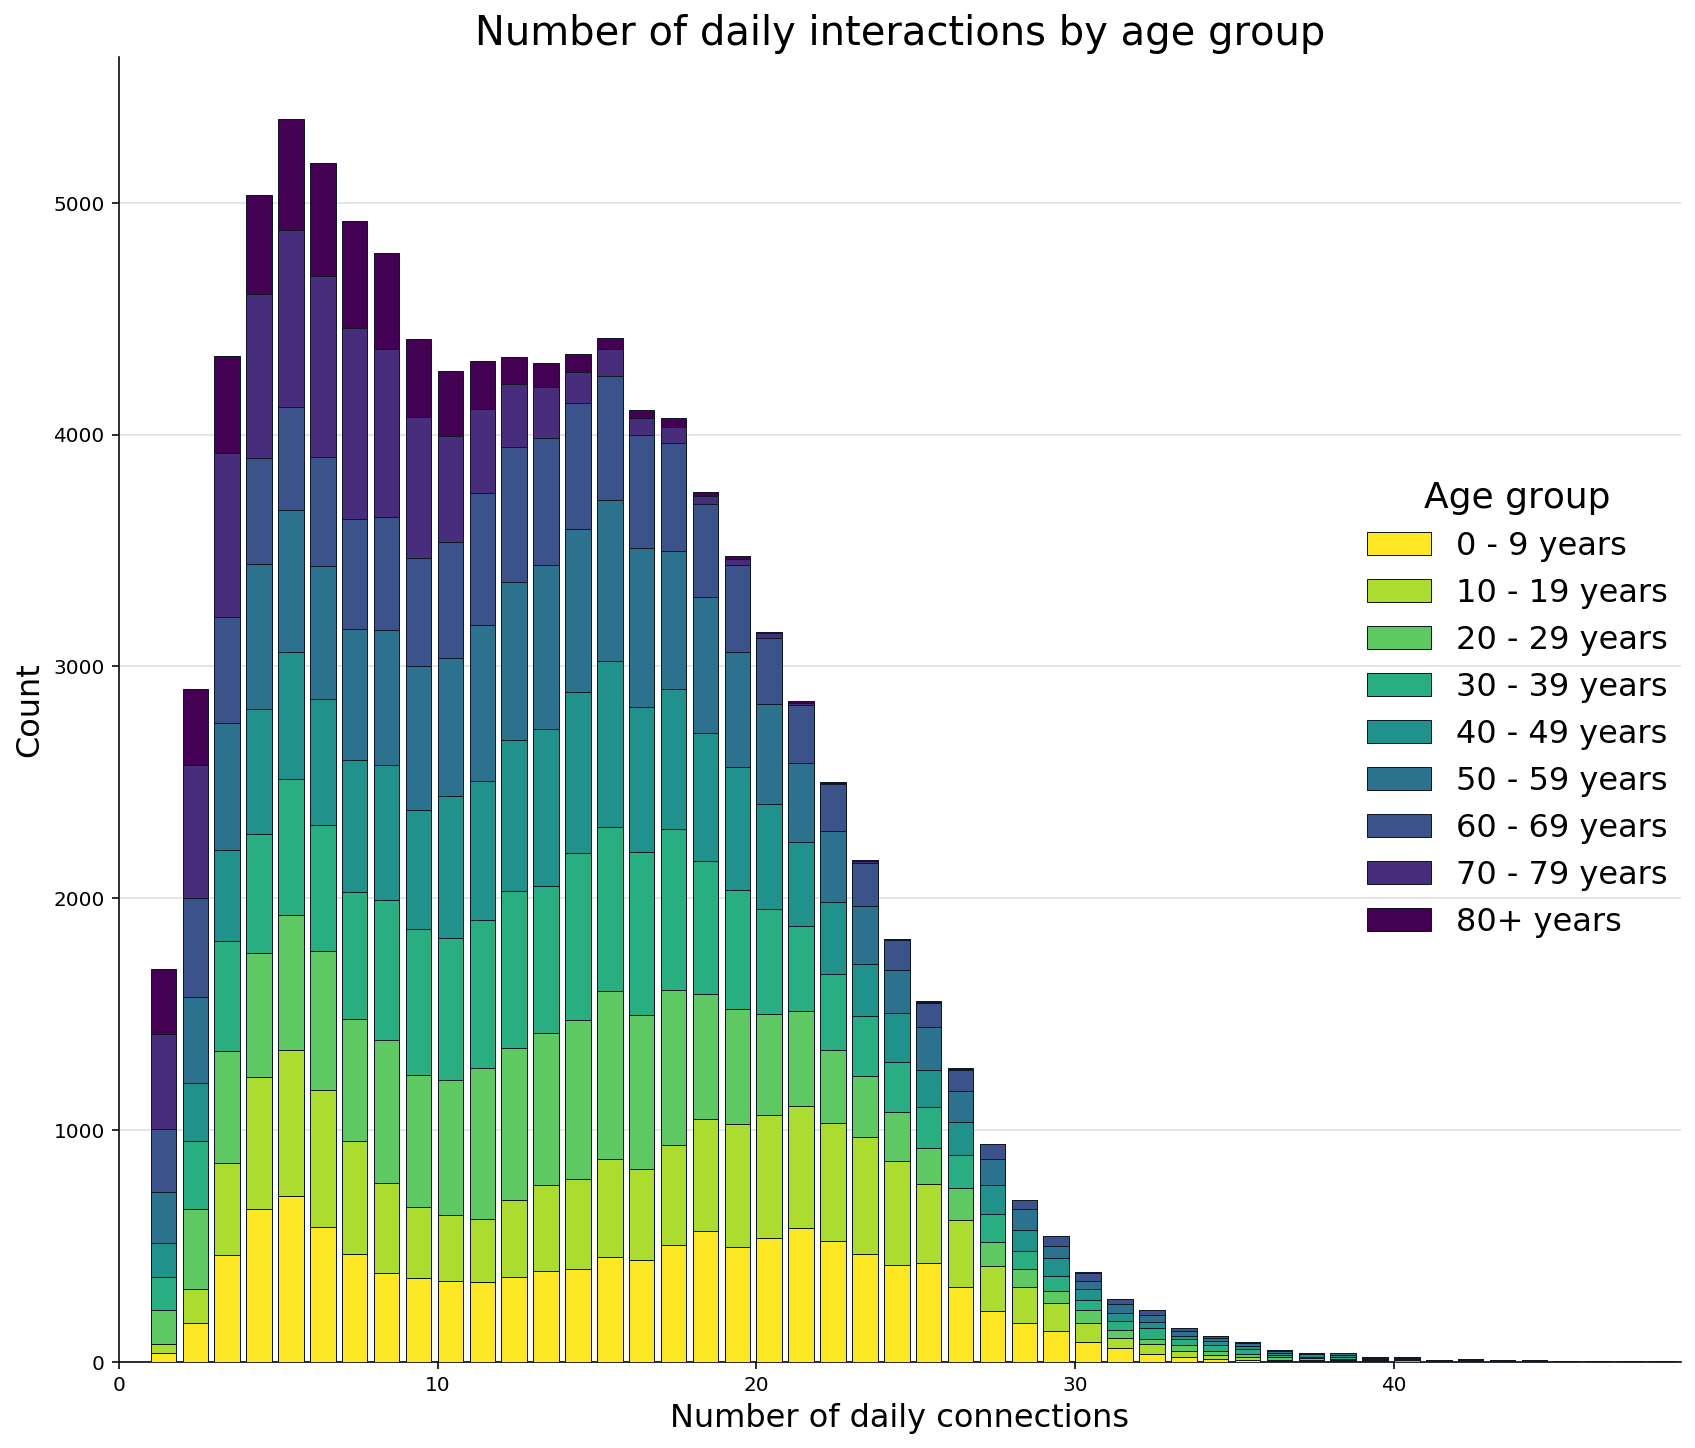

In [65]:
# Plot histogram of interaction by network type
fig, ax = plotting.PlotInteractionsByAge(df_interact)


# Transmission network <a class="anchor" id="transmission-network"></a>
[[Home](#home)]


### Proportion of all transmission from infectious status of source

In [75]:
# Remove seed cases
df_trans = df_trans[df_trans["infector_status"] != EVENT_TYPES.UNINFECTED.value]

# Calculate percent transmissions by disease status of the infector
percent_trans_infector_status = 100*df_trans["infector_status"].value_counts()/df_trans.shape[0]
percent_trans_infector_status = percent_trans_infector_status.reset_index()

# Summarise DataFrame
percent_trans_infector_status.columns = ["infector_status", "Percent transmissions"]
percent_trans_infector_status["name"] = percent_trans_infector_status.infector_status.map(lambda x: plotting.EVENT_TYPE_STRING[EVENT_TYPES(x).value])

display(percent_trans_infector_status[percent_trans_infector_status["Percent transmissions"] > 0][["Percent transmissions", "name"]].style.hide_index().set_precision(2))

Percent transmissions,name
32.63,Presymptomatic (mild)
24.38,Symptomatic (mild)
19.68,Presymptomatic (severe)
13.57,Symptomatic (severe)
9.74,Asymptomatic


### Proportion of all transmission from infectious status of source, through time

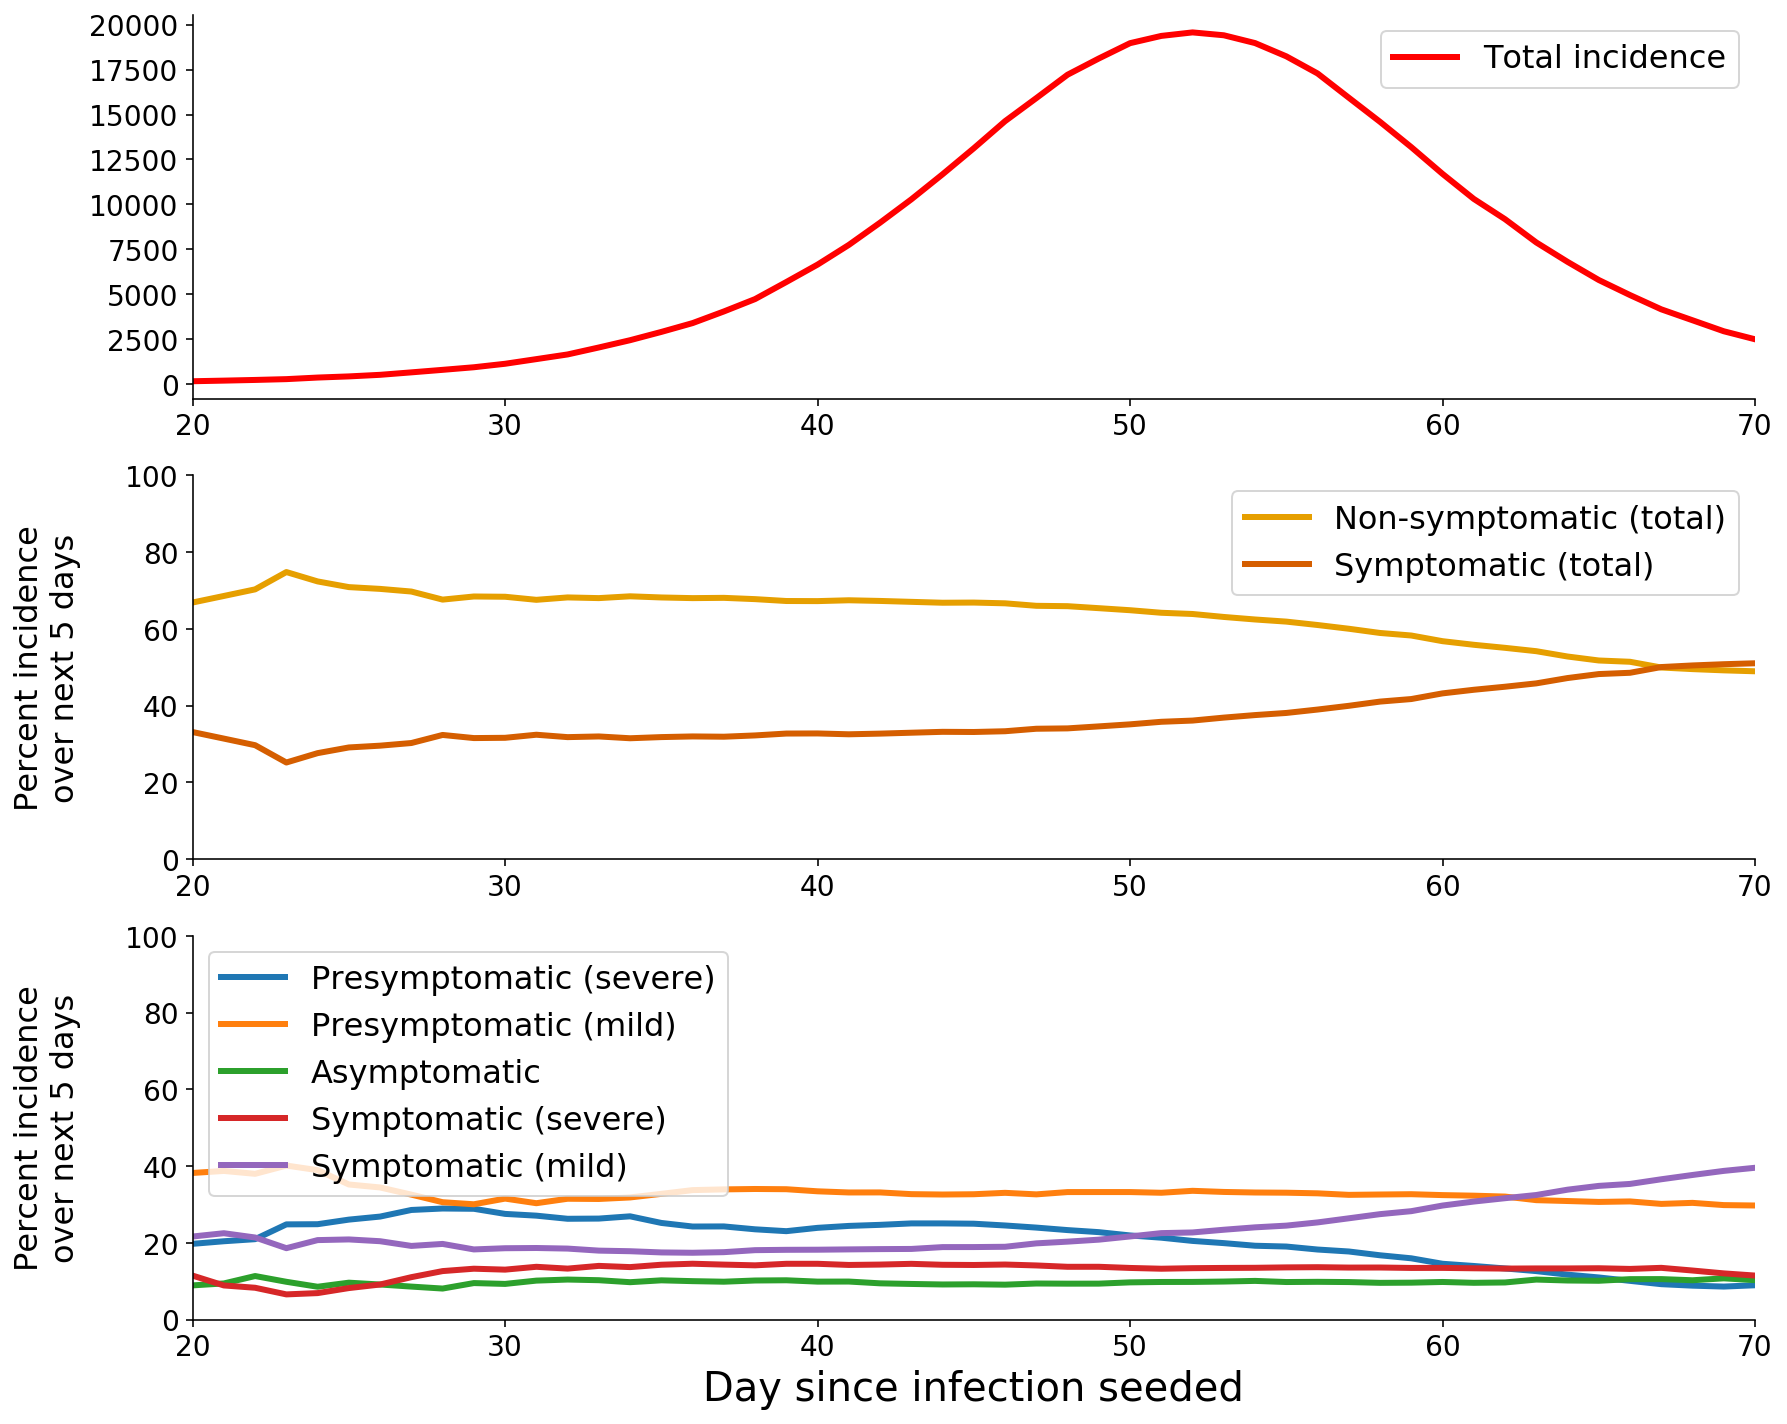

In [89]:
plt.rcParams['figure.figsize'] = [14, 12]

# Define non-symptomatic and symptomatic values
nonsymptomatic_status = [
    EVENT_TYPES.ASYMPTOMATIC.value, 
    EVENT_TYPES.PRESYMPTOMATIC.value, 
    EVENT_TYPES.PRESYMPTOMATIC_MILD.value]

symptomatic_status = [
    EVENT_TYPES.SYMPTOMATIC.value, 
    EVENT_TYPES.SYMPTOMATIC_MILD.value]

fig, ax = plotting.ProportionTransmissionsThroughTime(df_trans, 
    groupvar = "infector_status", groups = infector_types, 
    nonsymptomatic_status = nonsymptomatic_status, 
    symptomatic_status = symptomatic_status,
    infectiontimevar = "time_infected", 
    event_types_label_dict = plotting.EVENT_TYPE_STRING,
    start = 20, stop = 70, window = 5, ylims = [0, 100])

### Generation time by infection status of source : fixme use infector type labels

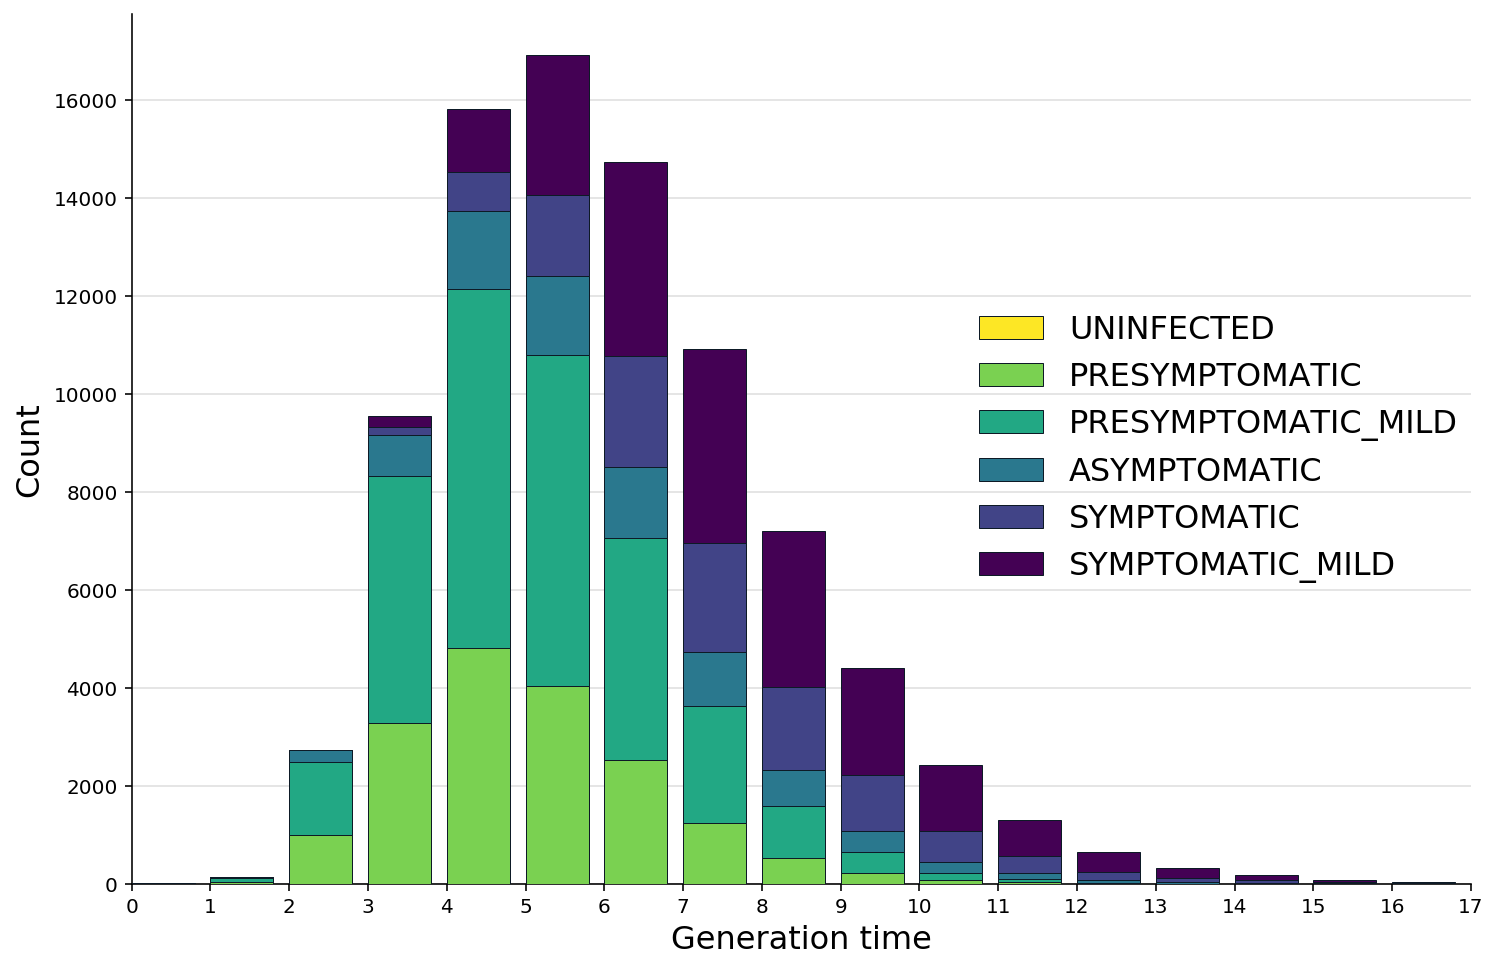

In [17]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plotting.PlotStackedHistByGroup(df_trans, 
        groupvar = "infector_status", countvar = "infector_infected_time", 
        NBINS = 18, group_labels = infector_labels,
        xlabel = "Generation time", ylabel = "Count")

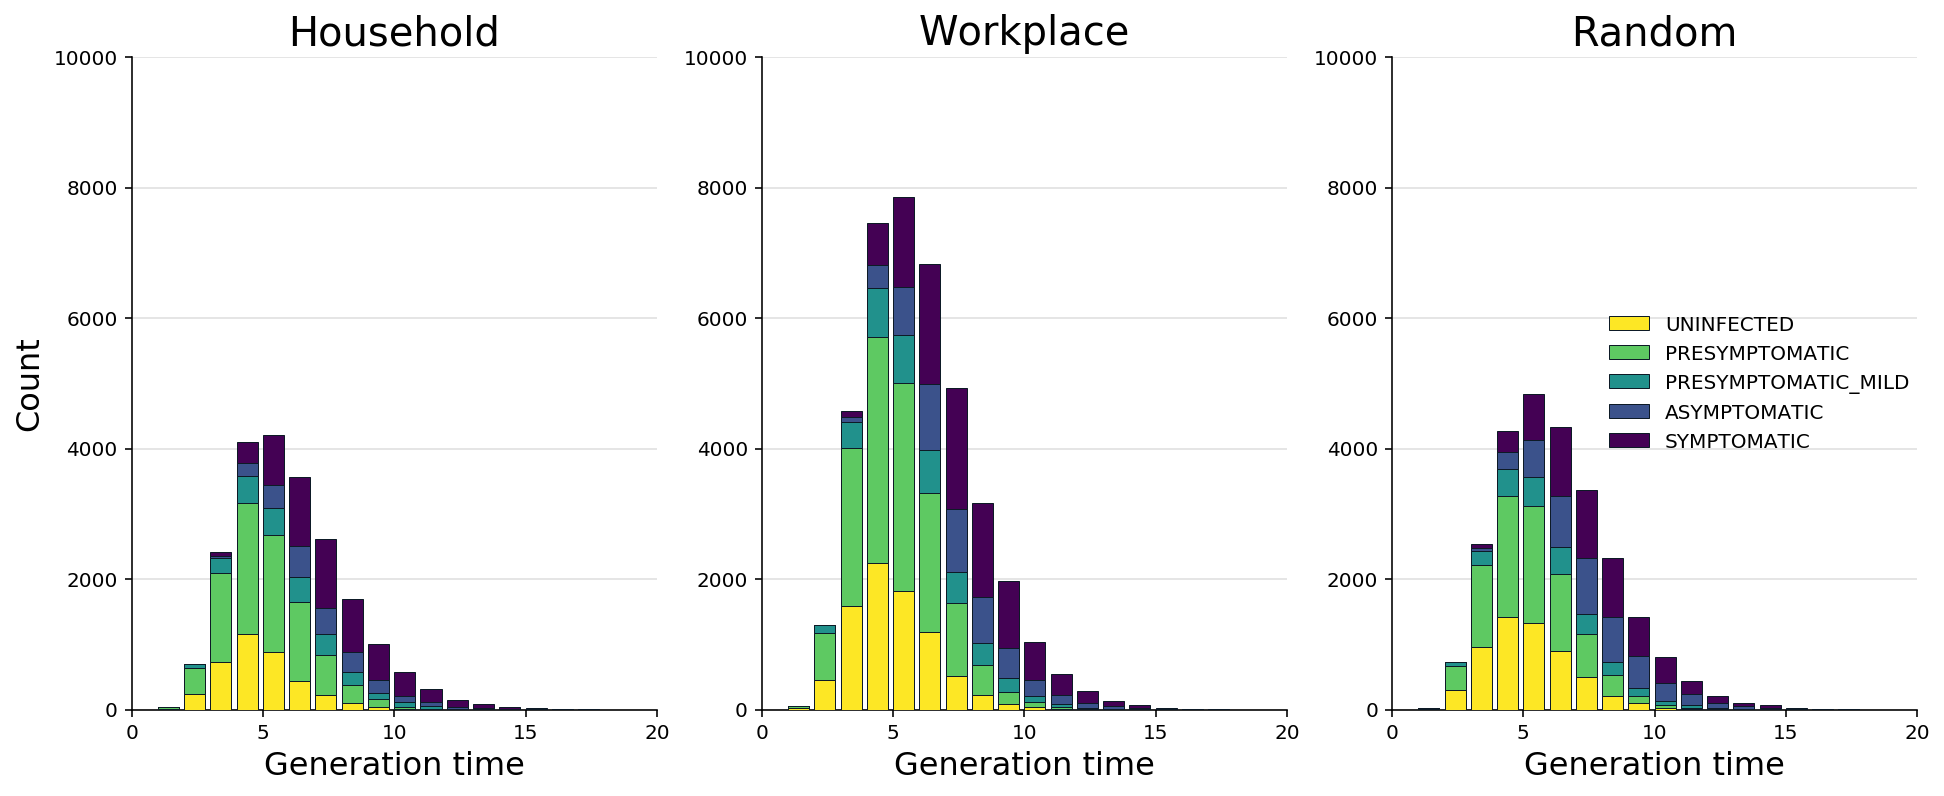

In [18]:
# fixme: use infector type labels
importlib.reload(plotting)
plt.rcParams['figure.figsize'] = [16, 6]

df_sub = df_trans[df_trans.infector_network >= 0]
max_gen_time = df_sub.infector_infected_time.max()

fig, ax = plotting.PlotStackedHistByGroupByPanel(df_sub, 
    groupvar = "infector_status", countvar = "infector_infected_time", NBINS = max_gen_time,
    panelvar = "infector_network",
    group_labels = infector_labels, ylims = [0, 10000],
    xlabel = "Generation time", ylabel = "Count", 
    panel_labels = ["Household", "Workplace", "Random"])

### Transmission events by age of infected individual and location of infection event

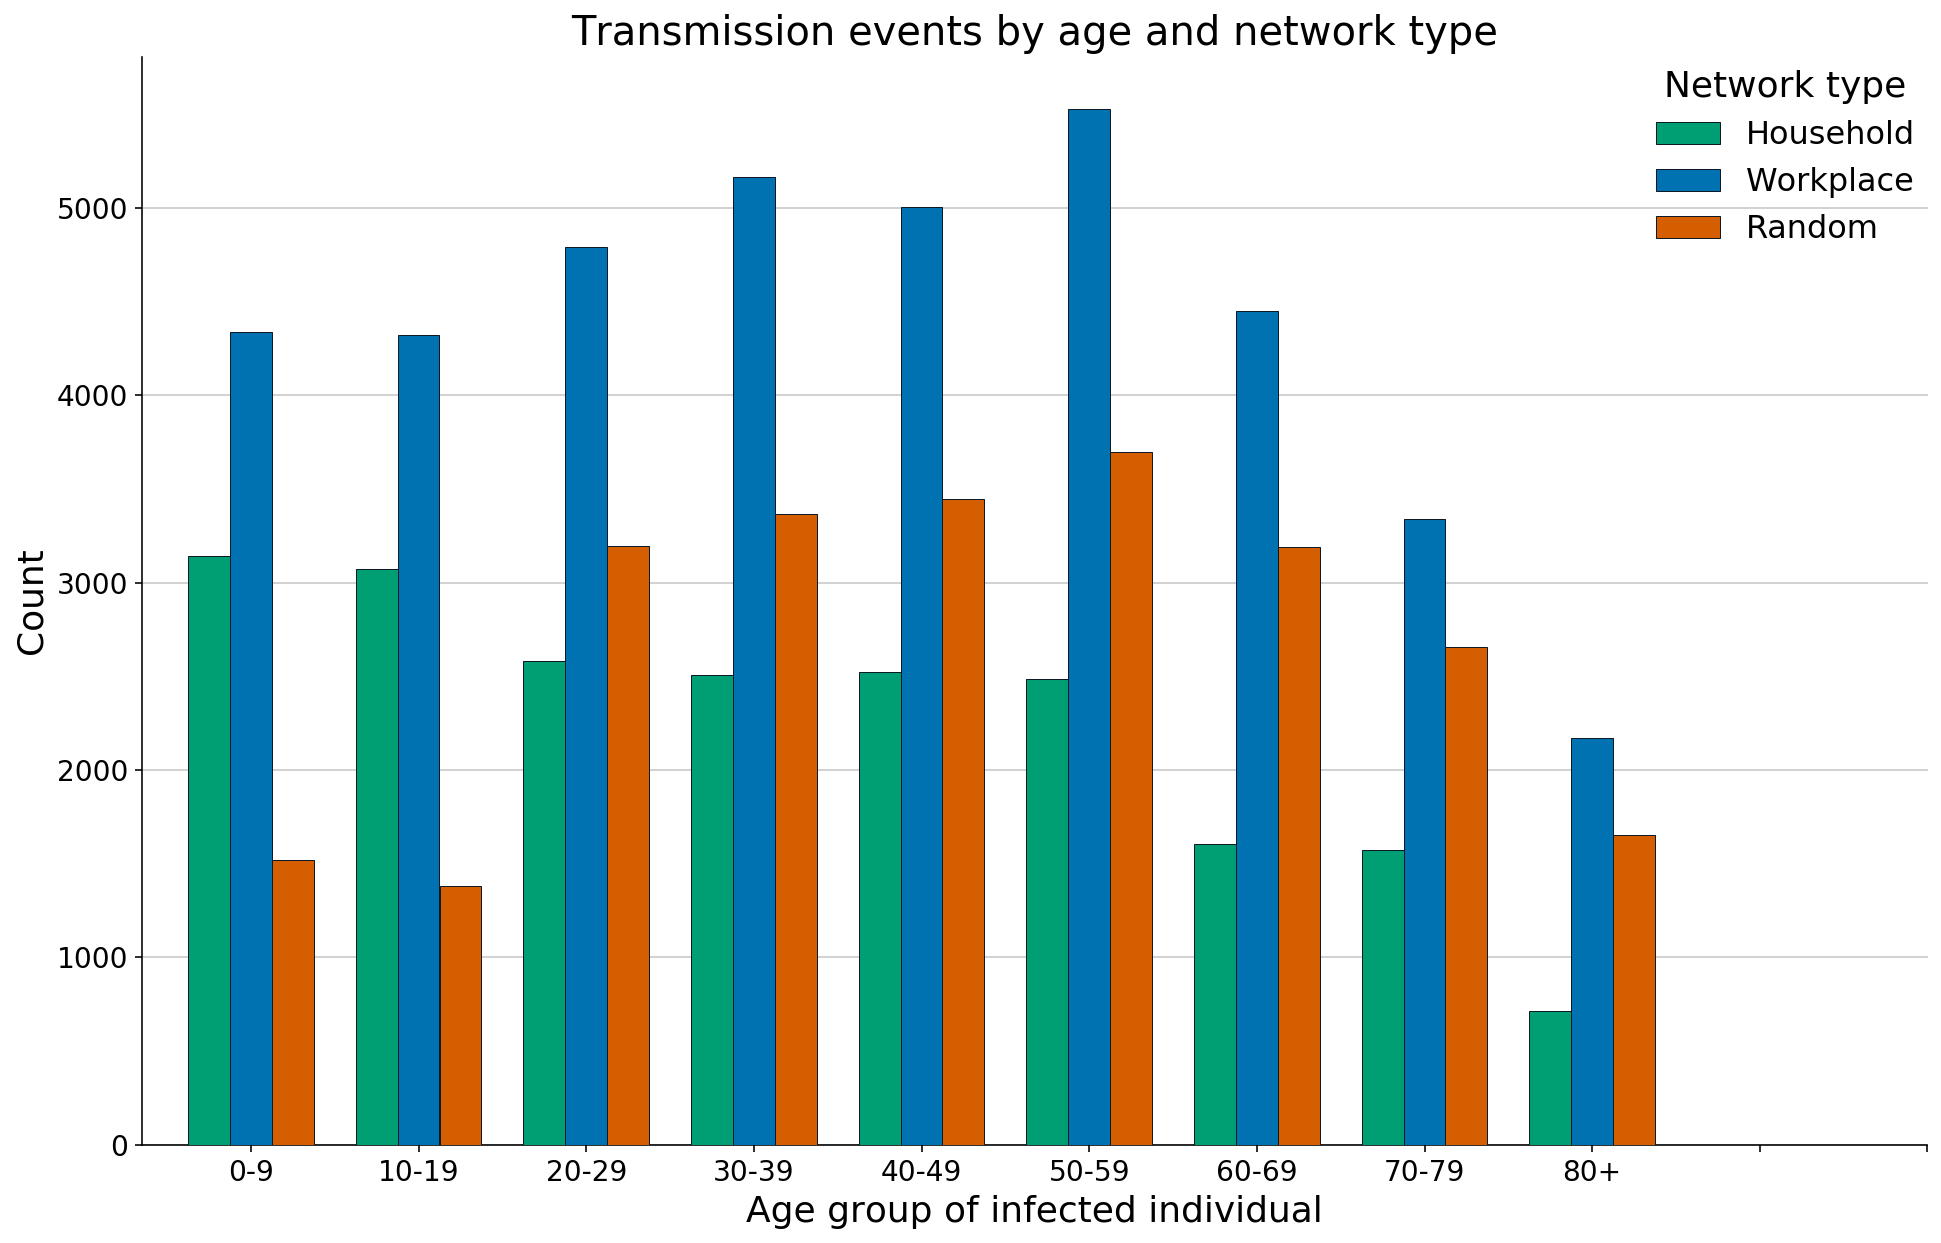

In [96]:
plt.rcParams['figure.figsize'] = [16, 10]

fig, ax = plotting.BarByGroup(df_trans[df_trans.infector_network >= 0], 
    groupvar = "infector_network", binvar = "age_group", 
    groups = [0, 1, 2], bins = n_age, group_colours = plotting.network_colours,
    group_labels = ["Household", "Workplace", "Random"], 
    xlabel = "Age group of infected individual",ylabel = "Count",
    title = "Transmission events by age and network type",
    legend_title = "Network type", xticklabels = age_group_labels)

### Transmission events stratified by age

Of all transmission events, the following figure shows the distribution of transmission events (2D histogram) stratified by the age of the source and recipient.  

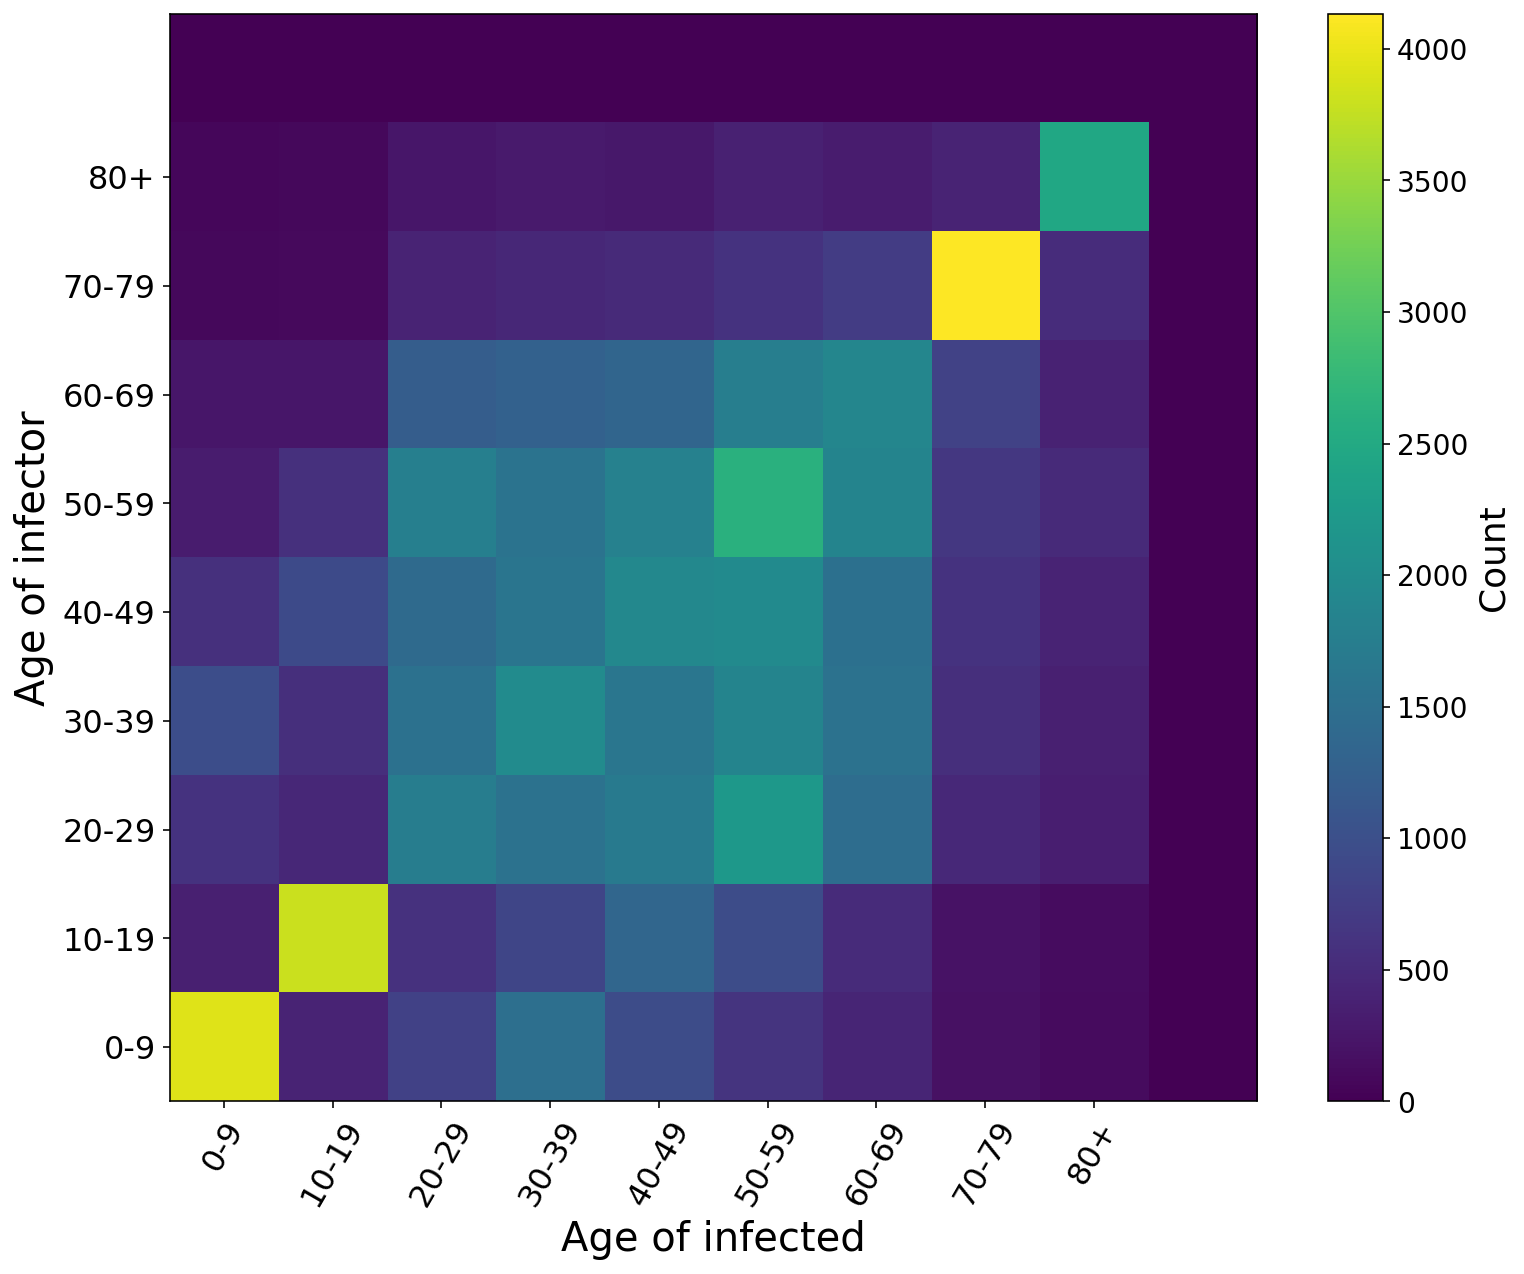

In [97]:
fig, ax = plotting.transmission_heatmap_by_age(df_trans, "age_group", "age_group_2", bins = n_age + 1,
        xlabel = "Age of infected", ylabel = "Age of infector", legend_title = "Count",
        xticklabels = age_group_labels, yticklabels = age_group_labels)

# Age-stratified outputs <a class="anchor" id="age-stratified-outputs"></a>

States that an individual may be in, stratified by age.  

[[Home](#home)]

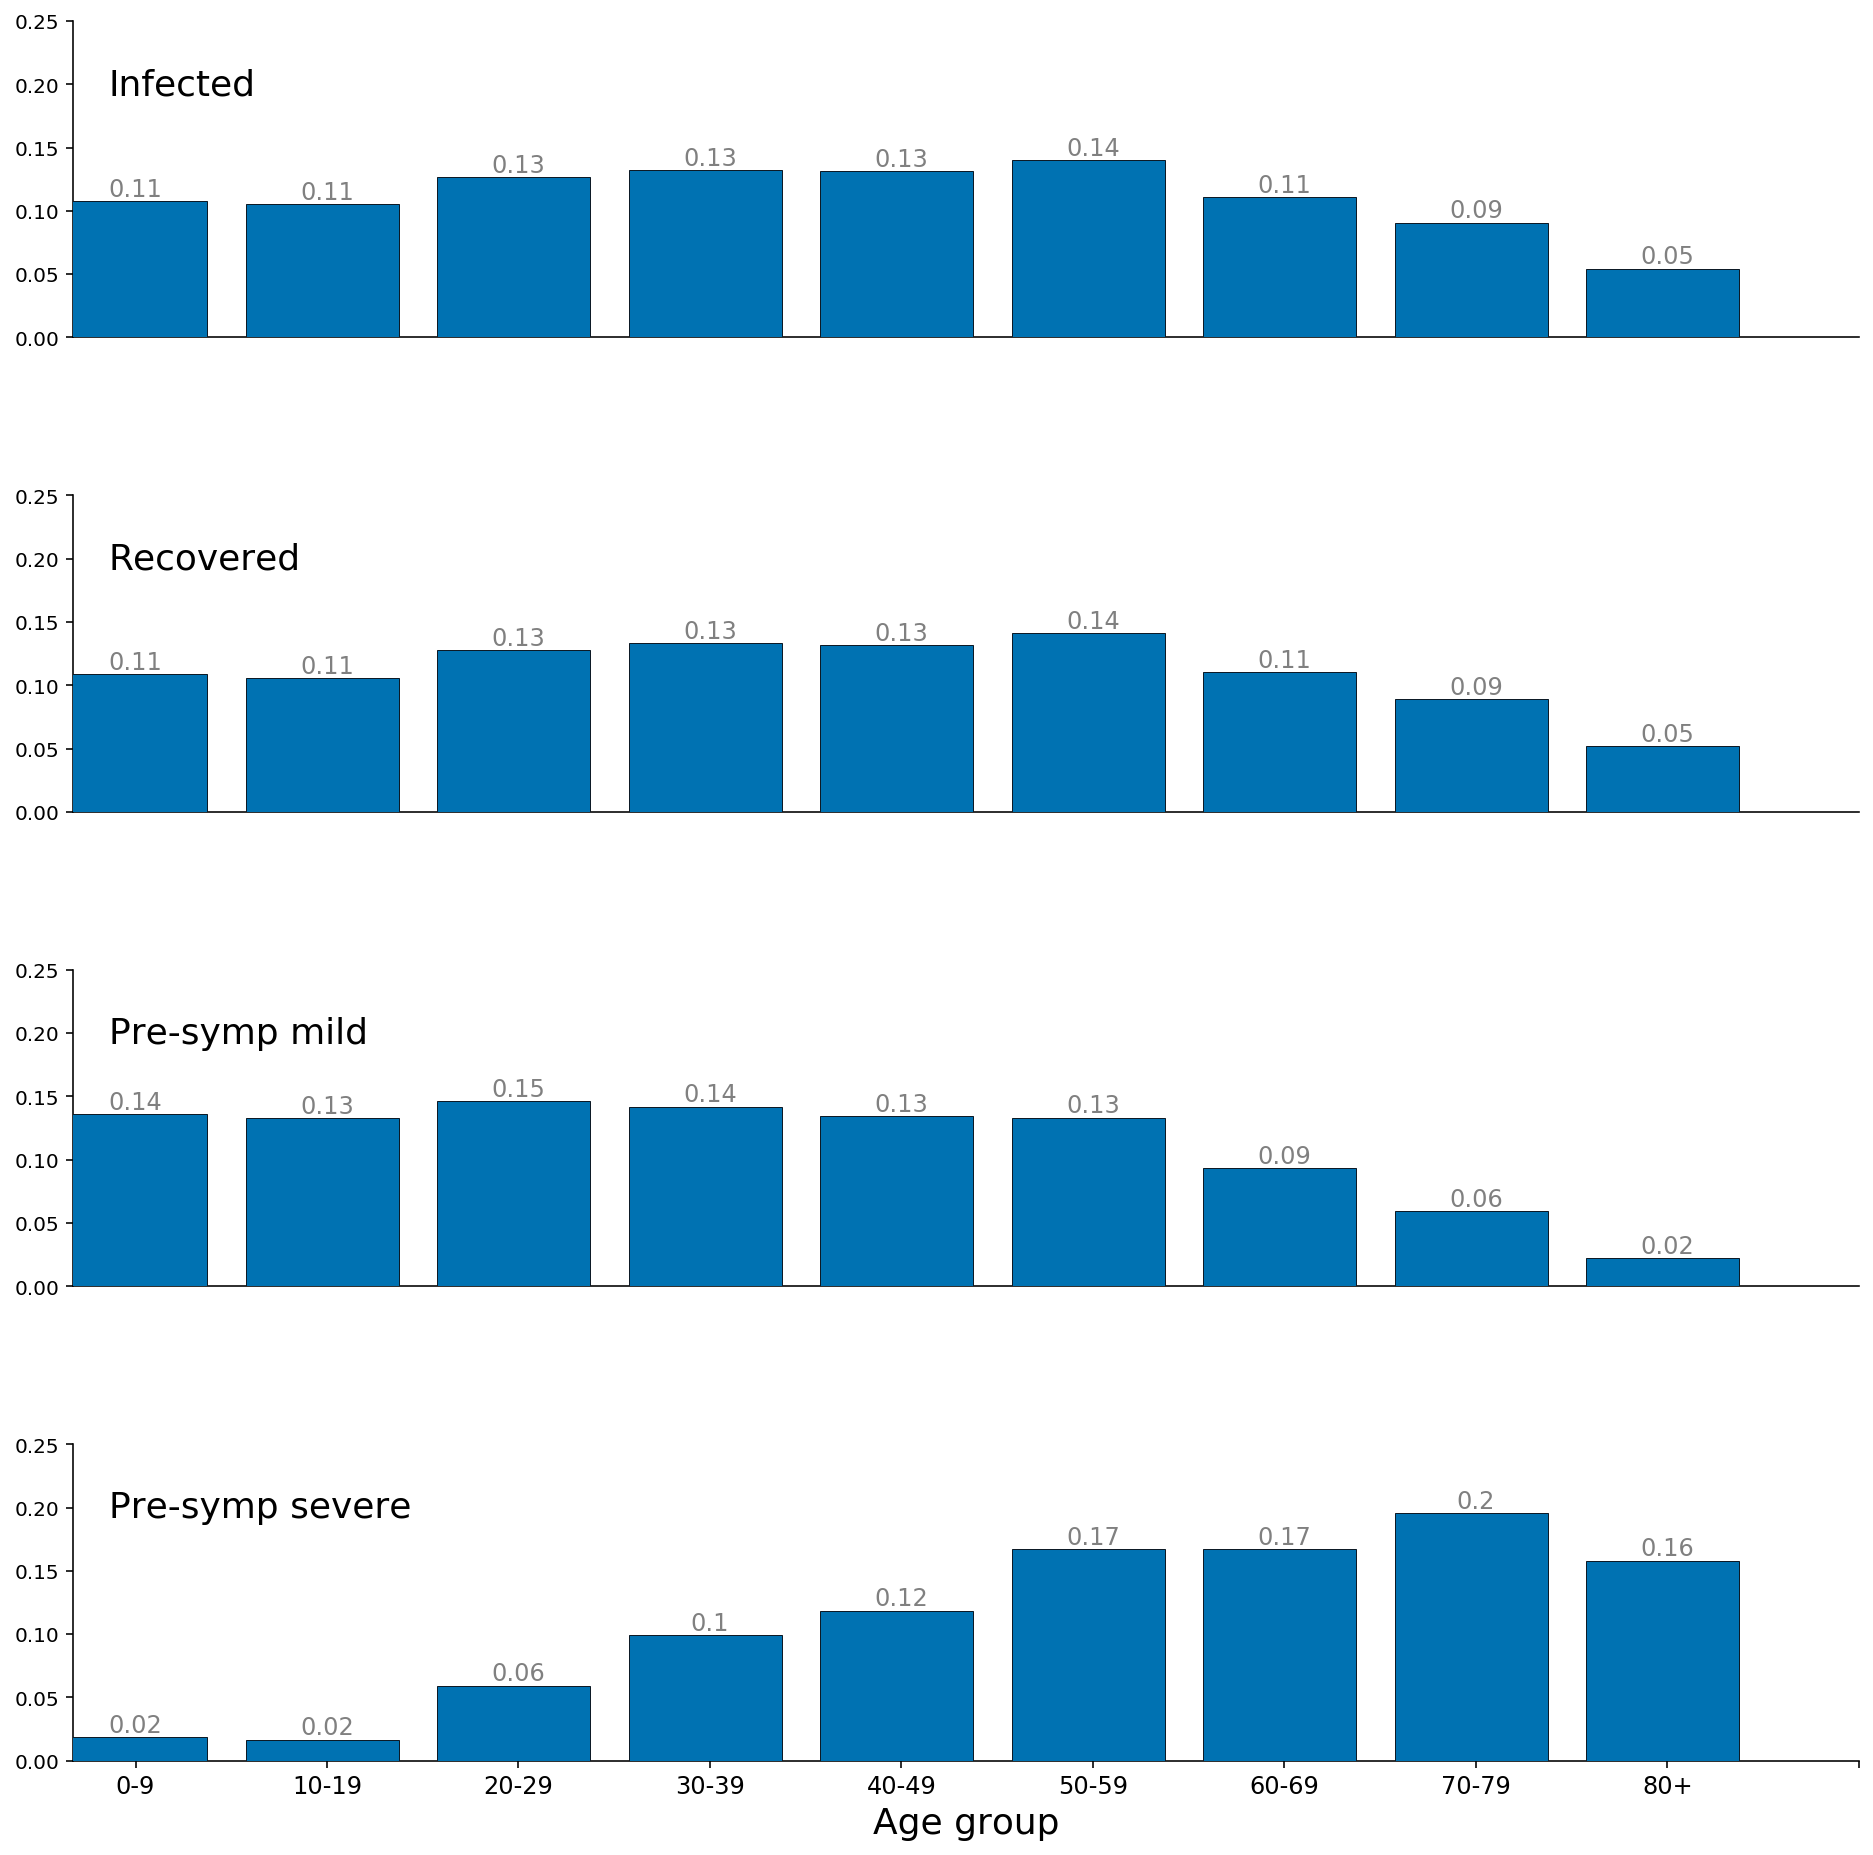

In [107]:
plt.rcParams['figure.figsize'] = [16, 16]
groupvars = ["time_infected", "time_recovered", "time_presypmtomatic_mild", "time_presypmtomatic_severe"]
labels = ["Infected", "Recovered", "Pre-symp mild", "Pre-symp severe"]

fig, ax = plotting.PlotHistByAge(df_indiv, groupvars = groupvars, group_labels = labels,
    NBINS = n_age -1 , density = True, xticklabels = age_group_labels, xlabel = "Age group",
    ylim = 0.25)

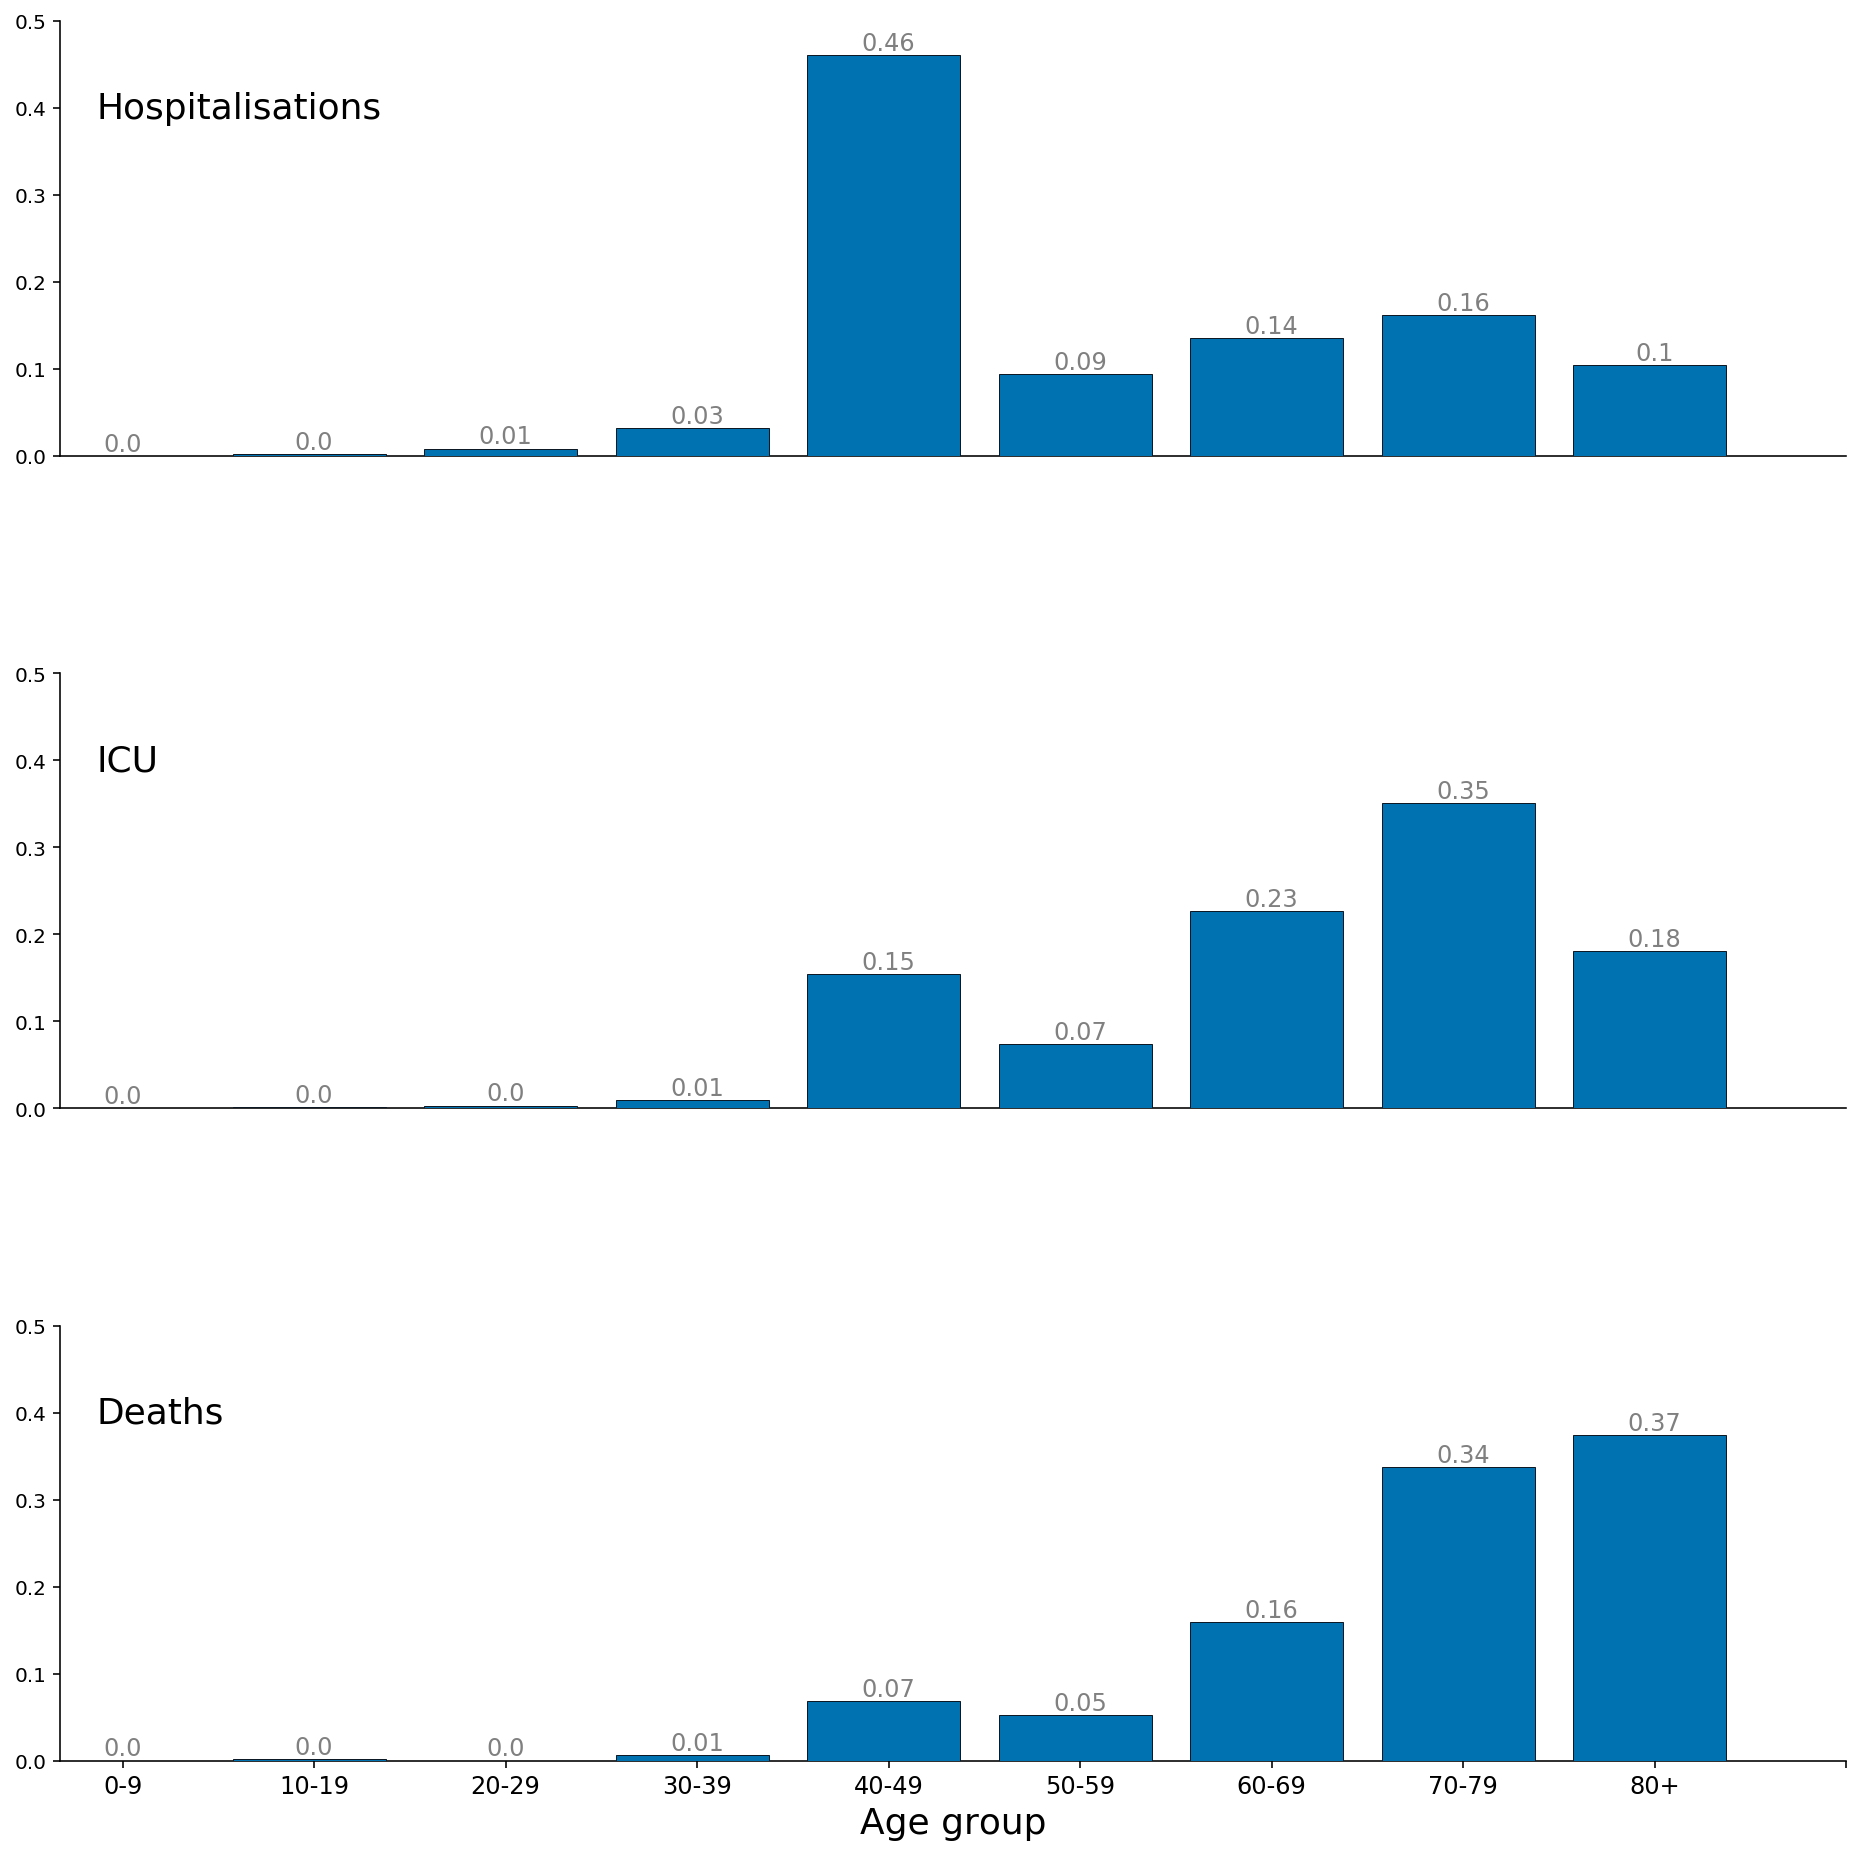

In [109]:
plt.rcParams['figure.figsize'] = [16, 16]
groupvars = ["time_hospitalised", "time_critical", "time_death"]
labels = ["Hospitalisations", "ICU", "Deaths"]

fig, ax = plotting.PlotHistByAge(df_indiv, groupvars = groupvars, group_labels = labels,
    NBINS = n_age -1 , density = True, xticklabels = age_group_labels, xlabel = "Age group",
    ylim = 0.5)

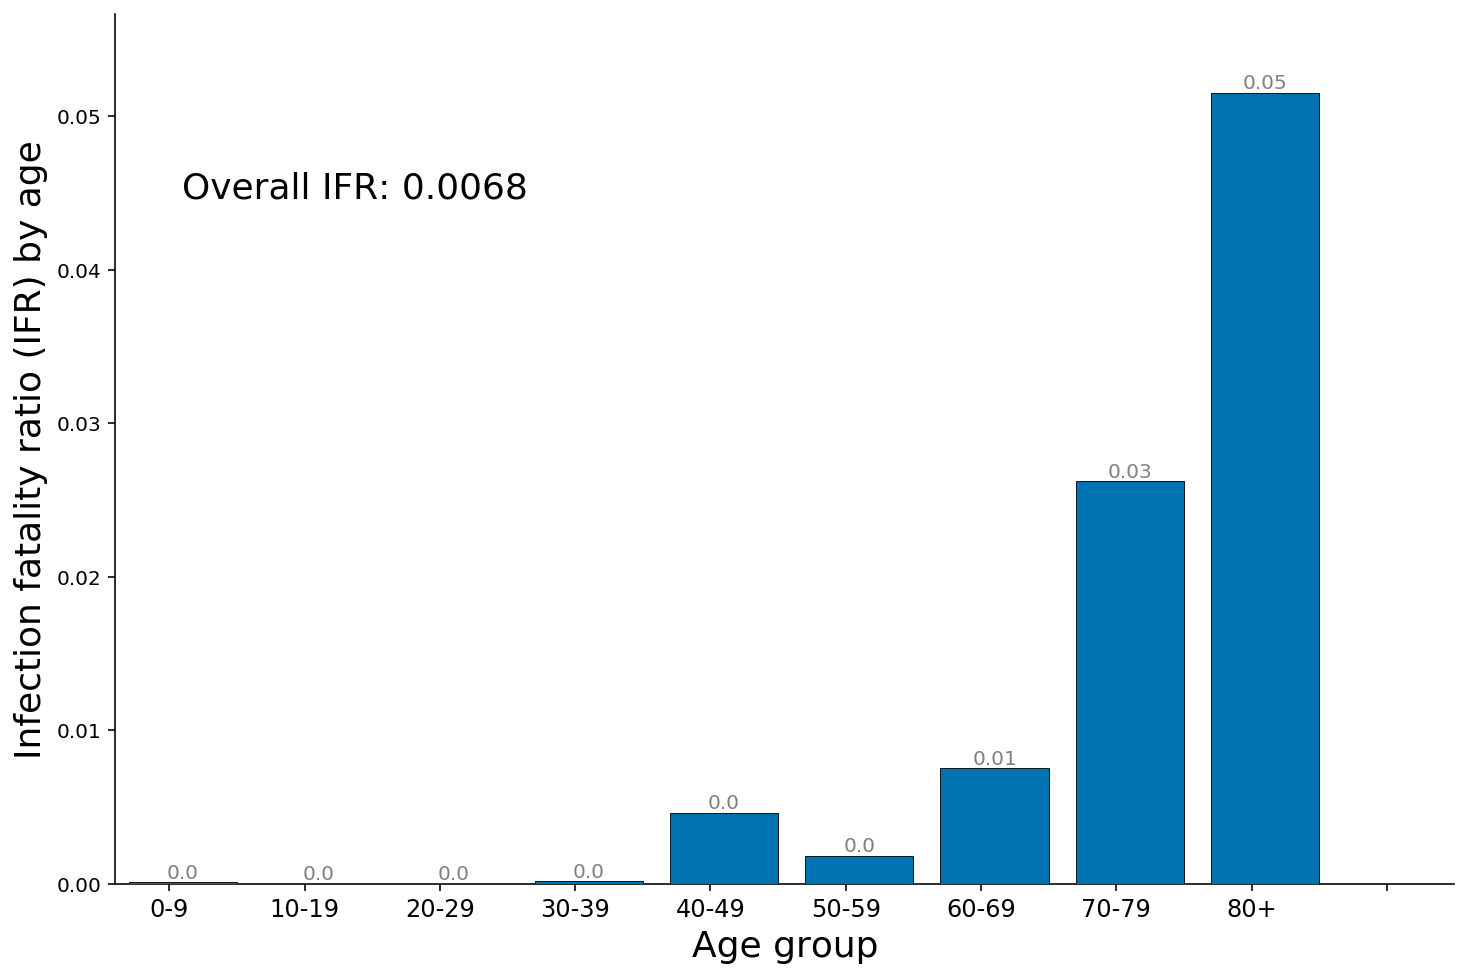

In [37]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plotting.PlotHistIFRByAge(df_indiv, "time_death", "time_infected", NBINS = n_age -1, 
    xticklabels = age_group_labels, xlabel = "Age group")